In [2]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import calendar
import scipy.stats as st

#CLEAN THE AIRBNB DATA
AirBnB_df = pd.read_csv('Resources/AB_US_2020.csv')

#Add date column that states month-year to match city sales df headers
last_review = AirBnB_df.loc[:,'last_review']
AirBnB_df['last_review'] = AirBnB_df['last_review'].fillna('00/00/00')

new_dates_list = []
for date in last_review:
    if int(date[:2]) == 0:
        new_date = '2019DONOTINCLUDE'
        new_dates_list.append(new_date)
        
    elif int(date[:2]) > 12:
        split_date = date.split('/')
        new_date = f'20{split_date[2]}-{split_date[1]}'
        new_dates_list.append(new_date)
        
    elif int(date[:2]) <= 12:
        split_date = date.split('/')
        new_date = f'20{split_date[2]}-{split_date[0]}'
        new_dates_list.append(new_date)

AirBnB_df['Month/Year'] = new_dates_list

#Change New York City to New York
AirBnB_df = AirBnB_df.replace("New York City","New York")

#Change NaN for review_per_month to 0
AirBnB_df['reviews_per_month'] = AirBnB_df['reviews_per_month'].fillna(0)


# SALES CITY DATA
#Pull in Sales City data
sales_city_df = pd.read_csv('Resources/House_Sales_City.csv')

#Group Sales City Data and check duplicate cities (will have counts > 1)
grouped_df = sales_city_df.groupby('RegionName').count()

#Pull rows where values = 1 to get non-duplicate cities
sales_city_list = grouped_df[grouped_df['RegionID']==1].index

#Unique cities in the AirBnB data
thelist = AirBnB_df['city'].unique()

#Pull sales city data from cities in AirBnB data
clean_city_df = sales_city_df[sales_city_df['RegionName'].isin(sales_city_list)]
clean_city_df = clean_city_df[clean_city_df['RegionName'].isin(thelist)]

merged_data = AirBnB_df.merge(clean_city_df, right_on = 'RegionName', left_on = 'city')


C:\Users\niraj\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Niraj's Work

In [3]:
#Create DataFrame of number of AirBnBs in each city
the_df = merged_data.groupby('city').agg({'id': ['count'],'Month/Year':['min']})

#Changes column headers to one level. Do not run more than once in kernel otherwise run previous set of code again followed by this code
the_df.columns.map('_'.join)
the_df.columns=the_df.columns.map('_'.join)

In [4]:
the_df

,id_count,Month/Year_min
city,,
Asheville,2074,2015-01
Boston,3339,2014-09
Chicago,6397,2013-08
Jersey City,2488,2014-06
Los Angeles,31536,2010-03
New Orleans,6408,2013-03
New York,45756,2011-08
Pacific Grove,179,2016-01
San Diego,12404,2012-05


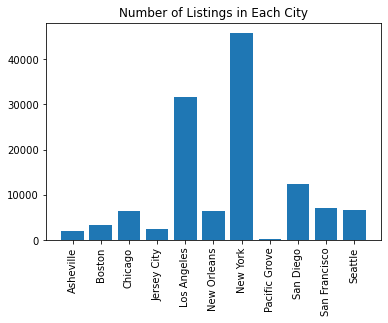

In [5]:
the_df.head(11)

#Create bar graph of cities and their count of listings
x = the_df.index
height = the_df.loc[:,'id_count']
plt.bar(x,height)
plt.xticks(rotation='vertical')
plt.title('Number of Listings in Each City')
plt.savefig('NK_ListingsPerCity.png',bbox_inches='tight')
plt.show()

In [6]:
#Create 2 lists. One for minimum price and the other for the month/year of the minimum price
min_price_list = []
min_year_list = []

#Create 2 lists. One for maximum price and the other for the month/year of the maximum price (which will always be 2020-02)
max_year_list = []
max_price_list = []

#List of all 11 cities
the_df_index = the_df.index

for city in the_df_index:
    city_MY = the_df.loc[city,'Month/Year_min']
    
    
    #FIND MINIMUM SALES PRICE VALUES
    min_value_df = clean_city_df.loc[clean_city_df['RegionName']==city,city_MY]
    min_value = min_value_df.tolist()[0]      

    #List of row indexes
    idx = clean_city_df.index
    idx_list = clean_city_df.index.tolist()

    #List of column indexes
    column_idx = clean_city_df.columns

    #Find row index
    city_idx = idx[clean_city_df['RegionName'] == city].tolist()[0]
    row_idx = idx_list.index(city_idx)

    #Find column index
    MY_idx = column_idx.get_loc(city_MY)

    #Iterate through data set to find first value that is not "nan"
    while np.isnan(min_value):

        min_value = clean_city_df.iloc[row_idx, MY_idx + 1 ]
        MY_idx = MY_idx + 1
    
    #Index into dataframe to collect the minimum sales price.
    minimum_MY = clean_city_df.columns[MY_idx]
    
    #Append price and year to respective lists
    min_price_list.append(min_value)
    min_year_list.append(minimum_MY)  
    
    
    
    #FIND MAXIMUM SALES PRICE VALUES
    max_value_df = clean_city_df.loc[clean_city_df['RegionName']==city,'2020-02'].tolist()[0]
    max_price_list.append(max_value_df)
    max_year_list.append('2020-02')

#Create list of number of listings for each city of AirBnBs
id_count = the_df.loc[:,'id_count'].tolist()       

In [7]:
#Calculate % increase from min MY to max MY

percent_chg_list = []

for city_index in range(0,len(the_df_index)):
    
    percent_change = 100*((max_price_list[city_index] - min_price_list[city_index])/ min_price_list[city_index])
    percent_chg_list.append(percent_change)
    
    #Change min and max month/year to printable format
    month = int(min_year_list[city_index][5:])
    month_name = calendar.month_name[month]
    
    year= min_year_list[city_index][:4]
    
    #Print analysis of each city
    print(f'The city of {the_df_index[city_index]} had {id_count[city_index]:,} listings between {month_name} {year} and February 2020.') 
    print(f'During this period, the housing prices increased by {percent_change:.2f}%')
    print('\n')


percent_str = []
for percent in percent_chg_list:
    string = f'{percent:.2f}%'
    percent_str.append(string)


the_df['Percent Change'] = percent_str
the_df

The city of Asheville had 2,074 listings between January 2015 and February 2020.
During this period, the housing prices increased by 47.85%


The city of Boston had 3,339 listings between September 2014 and February 2020.
During this period, the housing prices increased by 51.36%


The city of Chicago had 6,397 listings between August 2013 and February 2020.
During this period, the housing prices increased by 31.30%


The city of Jersey City had 2,488 listings between August 2016 and February 2020.
During this period, the housing prices increased by 48.00%


The city of Los Angeles had 31,536 listings between March 2010 and February 2020.
During this period, the housing prices increased by 110.82%


The city of New Orleans had 6,408 listings between March 2013 and February 2020.
During this period, the housing prices increased by 60.06%


The city of New York had 45,756 listings between August 2011 and February 2020.
During this period, the housing prices increased by 20.71%


The city

,id_count,Month/Year_min,Percent Change
city,,,
Asheville,2074,2015-01,47.85%
Boston,3339,2014-09,51.36%
Chicago,6397,2013-08,31.30%
Jersey City,2488,2014-06,48.00%
Los Angeles,31536,2010-03,110.82%
New Orleans,6408,2013-03,60.06%
New York,45756,2011-08,20.71%
Pacific Grove,179,2016-01,19.07%
San Diego,12404,2012-05,78.80%


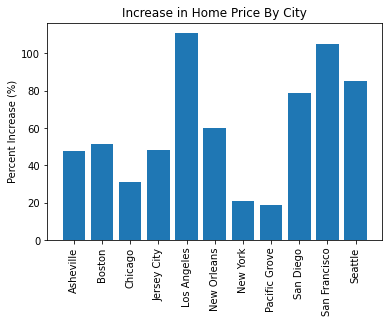

In [8]:
#Plot bar chart of % Change
plt.bar(x,percent_chg_list)
plt.xticks(rotation='vertical')
plt.title('Increase in Home Price By City')
plt.ylabel("Percent Increase (%)")
plt.savefig('PNG Files/NK_PercentChangePerCity.png',bbox_inches='tight')
plt.show()

The correlation between both factors is 0.06


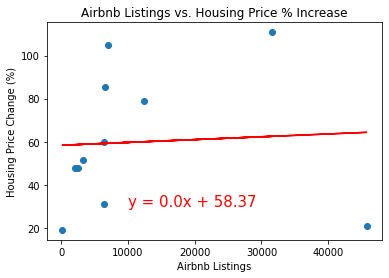

From the given data, it appears that the Airbnb listing count has little to no effect on the change in housing prices over multiple years


In [8]:
#Generate scatter plot of # of AirBnBs vs 2020-2 House Value

x_values = the_df.loc[:,'id_count'].tolist()
y_values = percent_chg_list

#Correlation
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

#Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
#Have to use series instead of list hence 'the_df.loc[:,'id_count']' instead of x_values
regress_values = the_df.loc[:,'id_count'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.title("Airbnb Listings vs. Housing Price % Increase")
plt.xlabel("Airbnb Listings")
plt.ylabel("Housing Price Change (%)")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10000,30),fontsize=15,color="red")
plt.savefig('PNG Files/NK_ScatterPlot.png')
plt.show()

print('From the given data, it appears that the Airbnb listing count has little to no effect on the change in housing prices over multiple years')

# Clay's Work

In [9]:
my_df = merged_data[['price', 'city', 'reviews_per_month', '2020-02']]
my_df

,price,city,reviews_per_month,2020-02
0,60,Asheville,1.14,309000.0
1,470,Asheville,1.03,309000.0
2,75,Asheville,0.81,309000.0
3,90,Asheville,2.39,309000.0
4,125,Asheville,0.52,309000.0
...,...,...,...,...
124204,109,Seattle,0.00,705600.0
124205,119,Seattle,0.00,705600.0
124206,299,Seattle,0.00,705600.0
124207,119,Seattle,0.00,705600.0


In [10]:
# Take AirBnB sum of reviews per month and group by city
reviews_per_month = merged_data.groupby('city')['reviews_per_month'].sum()
reviews_per_month

city
Asheville         5550.36
Boston            3787.76
Chicago           9188.90
Jersey City       2894.34
Los Angeles      36333.25
New Orleans      10047.80
New York         31045.83
Pacific Grove      318.04
San Diego        17206.46
San Francisco     7400.50
Seattle          10609.22
Name: reviews_per_month, dtype: float64

Text(0, 0.5, 'Reviews per Month')

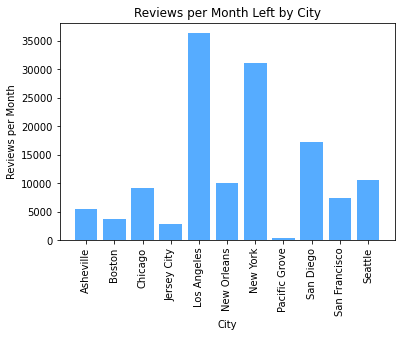

In [11]:
city = ['Asheville', 'Boston', 'Chicago', 'Jersey City', 'Los Angeles', 'New Orleans', 'New York', 'Pacific Grove', 'San Diego', 'San Francisco', 'Seattle']
rpm = [5550.36, 3787.76, 9188.90, 2894.34, 36333.25, 10047.80, 31045.83, 318.04, 17206.46, 7400.50, 10609.22]

plt.bar(city, rpm, color='dodgerblue', alpha=.75)
plt.xticks(rotation = 90)
plt.title('Reviews per Month Left by City')
plt.xlabel('City')
plt.ylabel('Reviews per Month')

In [12]:
number_of_reviews = merged_data.groupby('city')['number_of_reviews'].sum()
number_of_reviews

city
Asheville         161983
Boston            126851
Chicago           273496
Jersey City        70037
Los Angeles      1113802
New Orleans       329407
New York         1032264
Pacific Grove      13437
San Diego         486335
San Francisco     319331
Seattle           366251
Name: number_of_reviews, dtype: int64

In [13]:
housing_prices = merged_data.groupby('city')['2020-02'].mean()
housing_prices

city
Asheville         309000.0
Boston            665400.0
Chicago           302900.0
Jersey City       517400.0
Los Angeles       760200.0
New Orleans       248100.0
New York          568300.0
Pacific Grove     971500.0
San Diego         619200.0
San Francisco    1364300.0
Seattle           705600.0
Name: 2020-02, dtype: float64

The r-squared value is: 0.0008361680252518058


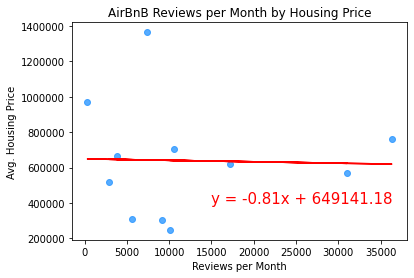

In [14]:
#reviews_per_month = merged_data.groupby('city')['reviews_per_month'].sum()
#housing_prices = merged_data.groupby('city')['2020-02'].mean()

x_values = reviews_per_month
y_values = housing_prices

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values,color='dodgerblue',alpha=.75)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(15000,400000),fontsize=15,color="red")

plt.xlabel('Reviews per Month')
plt.ylabel('Avg. Housing Price')
plt.ticklabel_format(style='plain')
plt.title('AirBnB Reviews per Month by Housing Price')
print(f"The r-squared value is: {rvalue**2}")

The r-squared value is: 0.0019126220197092567


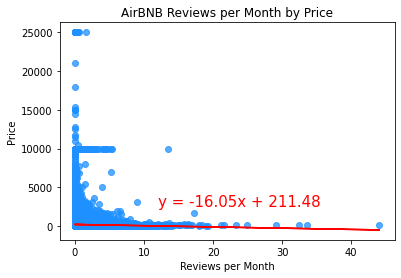

In [15]:
x_values = my_df['reviews_per_month']
y_values = my_df['price']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values, color='dodgerblue',alpha=.75)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(12,2550),fontsize=15,color="red")

plt.xlabel('Reviews per Month')
plt.ylabel('Price')
plt.title('AirBNB Reviews per Month by Price')
print(f"The r-squared value is: {rvalue**2}")

# "There is a strong, negative, nonlinear association between the two variables."

# Grace's Work

In [16]:
room_type_df = merged_data.groupby(['city','room_type'])
mean_df = room_type_df.mean()['price']
mean_df

city           room_type      
Asheville      Entire home/apt    217.679929
               Hotel room         288.894737
               Private room        96.989011
               Shared room         66.285714
Boston         Entire home/apt    209.967623
               Hotel room         223.444444
               Private room        94.322242
               Shared room        129.875000
Chicago        Entire home/apt    176.388548
               Hotel room         518.479452
               Private room        87.431533
               Shared room         49.688889
Jersey City    Entire home/apt    171.609159
               Hotel room          97.225806
               Private room        73.588670
               Shared room         91.019608
Los Angeles    Entire home/apt    294.598539
               Hotel room         152.019108
               Private room        96.918077
               Shared room         52.363806
New Orleans    Entire home/apt    183.962107
               Hotel roo

In [17]:
merged_data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.651460,-82.627920,Private room,60,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.597790,-82.555400,Entire home/apt,470,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.606700,-82.555630,Entire home/apt,75,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.578640,-82.595780,Entire home/apt,90,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.614420,-82.541270,Private room,125,...,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0,310900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124204,43805501,"Modern Boutique Apt in S. Lake Union, Gym +Pet...",218805459,Eric,Cascade,South Lake Union,47.624490,-122.335400,Entire home/apt,109,...,699000.0,690700.0,690800.0,684800.0,697300.0,692100.0,701700.0,701400.0,705600.0,NaN
124205,43807087,Beautiful & Bright Downtown Studio,130366604,Logan,Downtown,Belltown,47.615020,-122.342490,Entire home/apt,119,...,699000.0,690700.0,690800.0,684800.0,697300.0,692100.0,701700.0,701400.0,705600.0,NaN
124206,43807576,3 BDRM/1.75 bath Top Queen Anne home@quiet street,7435040,Chengying,Queen Anne,West Queen Anne,47.639570,-122.360840,Entire home/apt,299,...,699000.0,690700.0,690800.0,684800.0,697300.0,692100.0,701700.0,701400.0,705600.0,NaN
124207,43807578,Perfect & Bright Downtown Studio,130366604,Logan,Downtown,Belltown,47.615070,-122.340490,Entire home/apt,119,...,699000.0,690700.0,690800.0,684800.0,697300.0,692100.0,701700.0,701400.0,705600.0,NaN


In [18]:
mycols = list(merged_data.columns)
mycols

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'city',
 'Month/Year',
 'Unnamed: 0',
 'RegionID',
 'RegionName',
 'StateName',
 'SizeRank',
 '2008-03',
 '2008-04',
 '2008-05',
 '2008-06',
 '2008-07',
 '2008-08',
 '2008-09',
 '2008-10',
 '2008-11',
 '2008-12',
 '2009-01',
 '2009-02',
 '2009-03',
 '2009-04',
 '2009-05',
 '2009-06',
 '2009-07',
 '2009-08',
 '2009-09',
 '2009-10',
 '2009-11',
 '2009-12',
 '2010-01',
 '2010-02',
 '2010-03',
 '2010-04',
 '2010-05',
 '2010-06',
 '2010-07',
 '2010-08',
 '2010-09',
 '2010-10',
 '2010-11',
 '2010-12',
 '2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '2011-10',
 '2011-11',
 '2011-12',
 '2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',


In [19]:
new_df_cols = ['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'city',
 'Month/Year',
 'Unnamed: 0',
 'RegionID',
 'RegionName',
 'StateName',
 'SizeRank','2020-01',
 '2020-02',
 '2020-03']

new_df = merged_data[new_df_cols]
new_df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,city,Month/Year,Unnamed: 0,RegionID,RegionName,StateName,SizeRank,2020-01,2020-02,2020-03
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.651460,-82.627920,Private room,60,...,Asheville,2020-02,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.597790,-82.555400,Entire home/apt,470,...,Asheville,2020-07,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.606700,-82.555630,Entire home/apt,75,...,Asheville,2019-11,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.578640,-82.595780,Entire home/apt,90,...,Asheville,2020-09,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.614420,-82.541270,Private room,125,...,Asheville,2015-10,390,50779,Asheville,North Carolina,391,299800.0,309000.0,310900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124204,43805501,"Modern Boutique Apt in S. Lake Union, Gym +Pet...",218805459,Eric,Cascade,South Lake Union,47.624490,-122.335400,Entire home/apt,109,...,Seattle,2019DONOTINCLUDE,23,16037,Seattle,Washington,24,701400.0,705600.0,NaN
124205,43807087,Beautiful & Bright Downtown Studio,130366604,Logan,Downtown,Belltown,47.615020,-122.342490,Entire home/apt,119,...,Seattle,2019DONOTINCLUDE,23,16037,Seattle,Washington,24,701400.0,705600.0,NaN
124206,43807576,3 BDRM/1.75 bath Top Queen Anne home@quiet street,7435040,Chengying,Queen Anne,West Queen Anne,47.639570,-122.360840,Entire home/apt,299,...,Seattle,2019DONOTINCLUDE,23,16037,Seattle,Washington,24,701400.0,705600.0,NaN
124207,43807578,Perfect & Bright Downtown Studio,130366604,Logan,Downtown,Belltown,47.615070,-122.340490,Entire home/apt,119,...,Seattle,2019DONOTINCLUDE,23,16037,Seattle,Washington,24,701400.0,705600.0,NaN


In [20]:
new_mean_df = new_df.groupby(by='city').mean()
new_mean_df

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Unnamed: 0,RegionID,SizeRank,2020-01,2020-02,2020-03
city,,,,,,,,,,,,,,,,
Asheville,2.682800e+07,9.575666e+07,35.578745,-82.556585,196.639344,4.964802,78.101736,2.676162,5.620058,163.318226,390.0,50779.0,391.0,299800.0,309000.0,310900.0
Boston,2.695210e+07,1.059110e+08,42.337520,-71.082978,170.331836,35.754118,37.990716,1.134400,28.746032,184.506739,25.0,44269.0,26.0,644300.0,665400.0,692200.0
Chicago,2.813857e+07,9.850262e+07,41.899049,-87.664042,153.020009,8.113178,42.753791,1.436439,13.598718,174.272159,3.0,17426.0,4.0,281400.0,302900.0,309200.0
Jersey City,2.860093e+07,1.089726e+08,40.726941,-74.054797,137.039791,8.834003,28.149920,1.163320,13.967846,183.807878,83.0,25320.0,84.0,498200.0,517400.0,583600.0
Los Angeles,2.631011e+07,1.005559e+08,34.046130,-118.315923,222.682046,18.371322,35.318430,1.152120,11.467529,173.790430,1.0,12447.0,2.0,738200.0,760200.0,NaN
New Orleans,2.635798e+07,1.092524e+08,29.958402,-90.074819,174.975343,8.180087,51.405587,1.568009,11.500312,175.231898,48.0,19594.0,49.0,250700.0,248100.0,249000.0
New York,2.309535e+07,8.437272e+07,40.729633,-73.950747,149.557413,8.767703,22.560189,0.678508,5.964813,120.740733,0.0,6181.0,1.0,571700.0,568300.0,573600.0
Pacific Grove,2.356141e+07,1.107012e+08,36.621463,-121.920831,251.111732,15.351955,75.067039,1.776760,7.290503,179.692737,2805.0,33300.0,2806.0,951000.0,971500.0,963700.0
San Diego,2.485052e+07,8.625672e+07,32.770178,-117.183116,318.820864,5.853354,39.207917,1.387170,13.222025,143.341745,8.0,54296.0,9.0,617000.0,619200.0,NaN


<AxesSubplot:xlabel='city'>

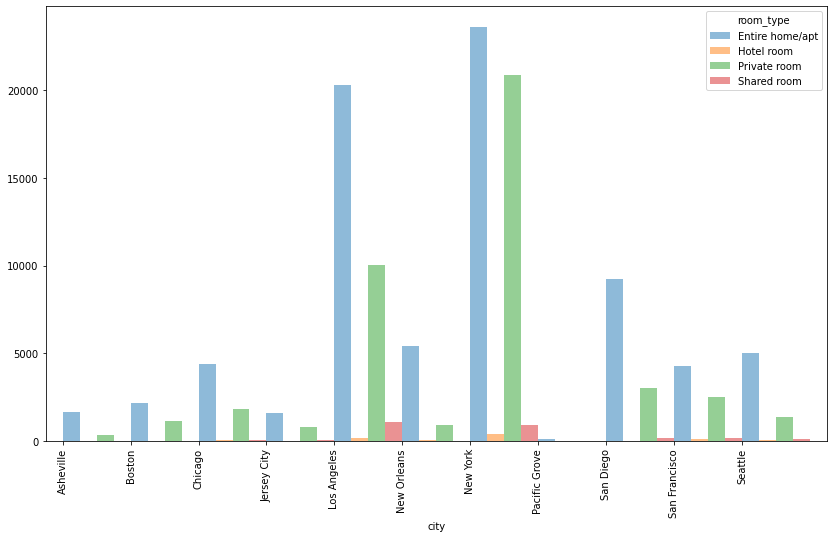

In [21]:
# roomtypes in different cities
room_type_df = merged_data.groupby(["city","room_type"]).size()
room_type_df = room_type_df.unstack()
room_type_df.plot(kind='bar', alpha=0.5, width=1.0, align="edge", figsize=(14,8))

Text(0.5, 1.0, 'Average Housing Price by Cities')

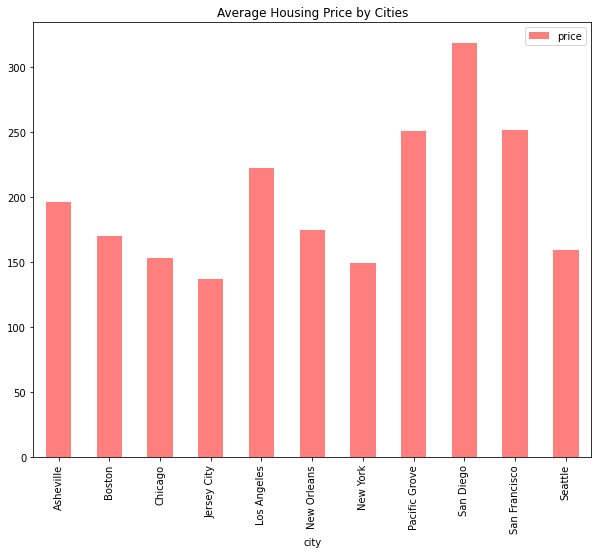

In [22]:
new_mean_df[['price']].plot(kind='bar',color='r', alpha=0.5, width=.5, align="center", figsize=(10,8))
plt.title('Average Housing Price by Cities')

Text(0.5, 1.0, 'Average AirBnB Price by Cities')

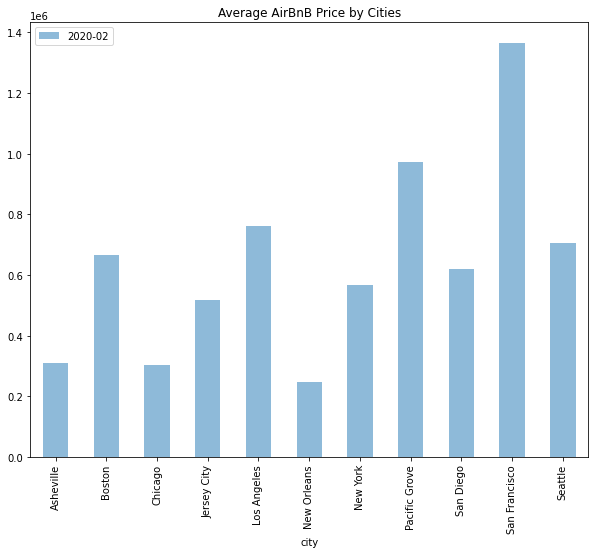

In [23]:
new_mean_df[['2020-02']].plot(kind='bar', alpha=0.5, width=0.5, align="center", figsize=(10,8))
plt.title('Average AirBnB Price by Cities')

In [24]:
x_values=new_mean_df['price'].tolist()
y_values=new_mean_df['2020-02'].tolist()

# correlation
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")


The correlation between both factors is 0.49


# Josh's Work

In [25]:
# got a list of every column using = [print(f'"{item}",') for item in merged_data.columns]/ got every column for a date
cols_i_want = ["2008-03","2008-04",
"2008-05",
"2008-06",
"2008-07",
"2008-08",
"2008-09",
"2008-10",
"2008-11",
"2008-12",
"2009-01",
"2009-02",
"2009-03",
"2009-04",
"2009-05",
"2009-06",
"2009-07",
"2009-08",
"2009-09",
"2009-10",
"2009-11",
"2009-12",
"2010-01",
"2010-02",
"2010-03",
"2010-04",
"2010-05",
"2010-06",
"2010-07",
"2010-08",
"2010-09",
"2010-10",
"2010-11",
"2010-12",
"2011-01",
"2011-02",
"2011-03",
"2011-04",
"2011-05",
"2011-06",
"2011-07",
"2011-08",
"2011-09",
"2011-10",
"2011-11",
"2011-12",
"2012-01",
"2012-02",
"2012-03",
"2012-04",
"2012-05",
"2012-06",
"2012-07",
"2012-08",
"2012-09",
"2012-10",
"2012-11",
"2012-12",
"2013-01",
"2013-02",
"2013-03",
"2013-04",
"2013-05",
"2013-06",
"2013-07",
"2013-08",
"2013-09",
"2013-10",
"2013-11",
"2013-12",
"2014-01",
"2014-02",
"2014-03",
"2014-04",
"2014-05",
"2014-06",
"2014-07",
"2014-08",
"2014-09",
"2014-10",
"2014-11",
"2014-12",
"2015-01",
"2015-02",
"2015-03",
"2015-04",
"2015-05",
"2015-06",
"2015-07",
"2015-08",
"2015-09",
"2015-10",
"2015-11",
"2015-12",
"2016-01",
"2016-02",
"2016-03",
"2016-04",
"2016-05",
"2016-06",
"2016-07",
"2016-08",
"2016-09",
"2016-10",
"2016-11",
"2016-12",
"2017-01",
"2017-02",
"2017-03",
"2017-04",
"2017-05",
"2017-06",
"2017-07",
"2017-08",
"2017-09",
"2017-10",
"2017-11",
"2017-12",
"2018-01",
"2018-02",
"2018-03",
"2018-04",
"2018-05",
"2018-06",
"2018-07",
"2018-08",
"2018-09",
"2018-10",
"2018-11",
"2018-12",
"2019-01",
"2019-02",
"2019-03",
"2019-04",
"2019-05",
"2019-06",
"2019-07",
"2019-08",
"2019-09",
"2019-10",
"2019-11",
"2019-12",
"2020-01",
"2020-02",
"2020-03"]

In [26]:
# break the type using bins into either privatley or company owned less than five is owned privatley
bins = [0,5,600]
type = ["Privatley Owned","Owned by a Company"]
merged_data["Type Property"] = pd.cut(merged_data["calculated_host_listings_count"], bins, labels=type)
#group the data by type
grouptype = merged_data.groupby("Type Property")
avgsale = grouptype[cols_i_want].mean()
avgsale
#made how many rows I am going to use smaller so it would properly fit on the graph
newavgsale=avgsale[avgsale.columns[119:144]]

In [27]:
# get the how long the list is of x values
x_value =list(newavgsale.columns.values)
lengthprices=len(x_value)
newavgsale

,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,...,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02
Type Property,,,,,,,,,,,,,,,,,,,,,
Privatley Owned,578777.763286,584995.266752,585660.823620,586461.788960,584094.630039,582561.227214,586287.645700,592878.683440,597850.321951,600389.500385,...,610685.795122,613369.998460,618106.240822,622168.721951,620583.150706,614748.548395,620661.870090,624974.862131,630414.079589,637299.749422
Owned by a Company,587568.778415,593082.697324,595391.823806,596197.689498,596556.197362,595955.176269,599814.675412,604959.849445,609626.615488,611294.834911,...,626476.619214,628731.750764,633409.968696,637620.518745,636740.523217,631551.337855,635424.524857,639735.790415,649106.100470,660107.550123


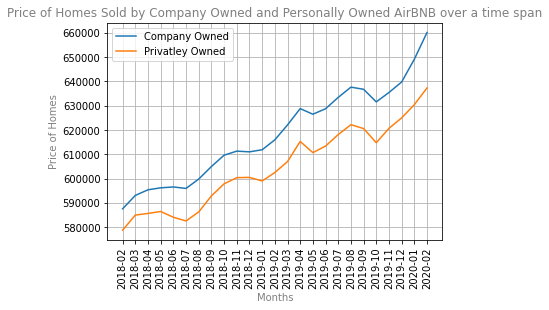

In [28]:
#getting the list values for my plotting
comowned=newavgsale.iloc[1,:]
privowned=newavgsale.iloc[0,:]
#plotting the graph
plt.xlabel("Months", color= "grey")
plt.title("Price of Homes Sold by Company Owned and Personally Owned AirBNB over a time span",color="grey")
plt.ylabel("Price of Homes", color= "grey")
plt.plot(comowned, label="Company Owned")
plt.plot(privowned, label= "Privatley Owned")
plt.xticks(range(0,lengthprices), rotation =90)
plt.grid()
plt.legend()
plt.show()

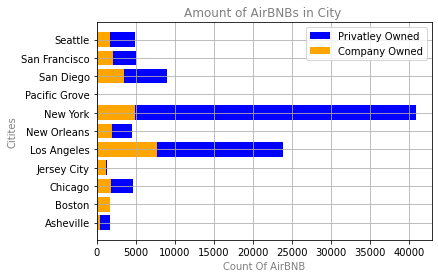

In [29]:
df = pd.DataFrame({"City":["Asheville","Boston","Chicago","Jersey City","Los Angeles","New Orleans","New York","Pacific Grove","San Diego","San Francisco","Seattle"],
                   "Privatley Owned":[1691,1675,4584,1333,23870,4496,40823,120,8937,4984,4862],
                  "Company Owned":[383,1664,1813,1155,7666,1912,4933,59,3467,2069,1713],
                 "Total":[2074,3339,6397,2488,31536,6408,45756,179,12404,7053,6575]})
#dfsorted = df.sort_values("Total",ascending=False)
dhbar= plt.barh(y= df["City"], width = df["Privatley Owned"], color = "blue",label="Privatley Owned")
dhbar= plt.barh(y= df["City"], width = df["Company Owned"], color = "orange",label="Company Owned")
plt.legend()
plt.xlabel("Count Of AirBNB", color= "grey")
plt.title("Amount of AirBNBs in City ",color="grey")
plt.ylabel("Citites", color= "grey")
plt.grid()
df1=df.style.hide_index()

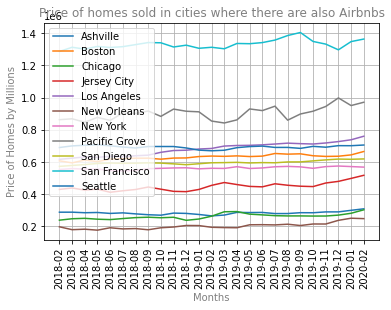

In [30]:
#grouped by city
pricecitygroup = merged_data.groupby("city")
#avg of prices in city
pricegrpcity=pricecitygroup[cols_i_want].mean()
pricegrpcity
newpricegrpcity = pricegrpcity[pricegrpcity.columns[119:144]]
newpricegrpcity
#each city list for the months
ashville = newpricegrpcity.iloc[0,:]
boston = newpricegrpcity.iloc[1,:]
chicago = newpricegrpcity.iloc[2,:]
jersey_city = newpricegrpcity.iloc[3,:]
los_angeles = newpricegrpcity.iloc[4,:]
new_orleans = newpricegrpcity.iloc[5,:]
new_york = newpricegrpcity.iloc[6,:]
pacific_grove = newpricegrpcity.iloc[7,:]
san_diego = newpricegrpcity.iloc[8,:]
san_francisco = newpricegrpcity.iloc[9,:]
seattle = newpricegrpcity.iloc[10,:]

plt.xlabel("Months", color= "grey")
plt.title("Price of homes sold in cities where there are also Airbnbs",color="grey")
plt.ylabel("Price of Homes by Millions", color= "grey")
plt.plot(ashville, label="Ashville")
plt.plot(boston, label="Boston")
plt.plot(chicago, label="Chicago")
plt.plot(jersey_city, label="Jersey City")
plt.plot(los_angeles, label="Los Angeles")
plt.plot(new_orleans, label="New Orleans")
plt.plot(new_york, label="New York")
plt.plot(pacific_grove, label="Pacific Grove")
plt.plot(san_diego, label="San Diego")
plt.plot(san_francisco, label="San Francisco")
plt.plot(seattle, label="Seattle")
plt.xticks(range(0,lengthprices), rotation =90)
plt.grid()
plt.legend(loc = "upper left")
plt.show()
#avgsale = grouptype[cols_i_want].mean()
#newpricegrpcity
#,(boston, label="Boston"))

In [31]:
newpricegrpcity

,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,...,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02
city,,,,,,,,,,,,,,,,,,,,,
Asheville,288100.0,288200,284800,286300,280500,284000,277700,272400,269400,282500,...,285900.0,286600.0,279500.0,279700.0,285000.0,284700.0,289900.0,290100.0,299800.0,309000.0
Boston,607300.0,594900,612000,602500,618000,621000,623700,623900,617700,624500,...,634000.0,636600.0,653000.0,648900.0,651000.0,638900.0,634800.0,636000.0,644300.0,665400.0
Chicago,238500.0,247400,250000,244600,242100,248600,254400,256800,253600,256600,...,276000.0,271500.0,266500.0,264900.0,265000.0,264100.0,264300.0,270000.0,281400.0,302900.0
Jersey City,429700.0,438500,425500,431200,412000,421300,429100,444600,431100,417700,...,448400.0,445700.0,464700.0,455600.0,449600.0,447300.0,469500.0,479700.0,498200.0,517400.0
Los Angeles,616800.0,624000,631300,629100,635300,633600,638900,642700,660300,671400,...,703800.0,706800.0,711800.0,717300.0,714100.0,711900.0,718400.0,727100.0,738200.0,760200.0
New Orleans,197300.0,179400,182400,176400,191400,184200,186300,178900,191300,196000,...,209800.0,210500.0,209100.0,213400.0,205200.0,214800.0,214600.0,237500.0,250700.0,248100.0
New York,553200.0,559400,555700,556300,547000,544300,548100,558700,560700,563100,...,559800.0,563200.0,570500.0,572800.0,569900.0,560800.0,571500.0,575100.0,571700.0,568300.0
Pacific Grove,863100.0,868700,847400,877300,858500,904800,902000,917000,883700,929000,...,929900.0,919600.0,947100.0,860100.0,898400.0,915800.0,945200.0,998400.0,951000.0,971500.0
San Diego,573000.0,578500,584100,591000,593500,591900,592700,594800,593200,588600,...,594200.0,596300.0,595300.0,600500.0,600800.0,607000.0,613300.0,618300.0,617000.0,619200.0


# Ting's Work

In [9]:
AirBnB_df = AirBnB_df.dropna(subset=['reviews_per_month'])
AirBnB_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,Month/Year
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville,2020-02
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville,2020-07
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville,2019-11
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville,2020-09
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville,2015-10


In [10]:
# Does the home price correlate with reviews per month?
# reviews_per_month
# price
# prices = AirBnB_df["prices"]
# reviews_per_mo = AirBnB_df["reviews_per_month"]

# Define function for creating linear agression and scatter plot
def linear_agression(x,y):
    print(f"The r-squared is : {round(st.pearsonr(x, y)[0],18)}")
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x, y, facecolor = "steelblue", edgecolor = "black")
    plt.plot(x,regress_values,"r-")
    return line_eq
# Define a fuction for annotating
def annotate(line_eq, a, b):
    plt.annotate(line_eq,(a,b),fontsize=15,color="red")


The r-squared is : -0.07761955677579999


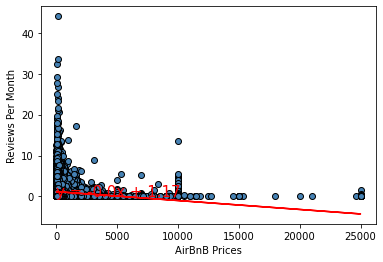

In [12]:
equation = linear_agression(AirBnB_df["price"], AirBnB_df["reviews_per_month"])
annotate(equation, 0, 0)
plt.xlabel("AirBnB Prices")
plt.ylabel("Reviews Per Month")
plt.savefig("PNG Files/Prices vs Reviews Per Month Linear Regression.png")

In [35]:
AirBnB_City_df = AirBnB_df[AirBnB_df["city"].isin(["New York", "Chicago", "San Francisco"])]
AirBnB_City_df = AirBnB_City_df[(AirBnB_City_df['price'] > 0)]
AirBnB_City_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,Month/Year
27736,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,15/12/19,2.56,1,353,Chicago,2019-12
27737,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,14/07/20,2.81,1,155,Chicago,2020-07
27738,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,08/03/20,2.81,1,321,Chicago,2020-08
27739,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,23/10/19,0.63,9,300,Chicago,2019-10
27740,10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,14/02/20,0.61,5,168,Chicago,2020-02


In [36]:
mean = AirBnB_City_df.groupby('city')['price'].mean()
mean

city
Chicago          153.043934
New York         149.639173
San Francisco    252.018857
Name: price, dtype: float64

In [37]:
median = AirBnB_City_df.groupby('city')['price'].median()
median

city
Chicago           99
New York         100
San Francisco    140
Name: price, dtype: int64

In [38]:
groupby_count1 = AirBnB_City_df.groupby(['city']).count()
groupby_count1

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Month/Year
city,,,,,,,,,,,,,,,,,
Chicago,6396,6396,6396,6396,0,6396,6396,6396,6396,6396,6396,6396,6396,6396,6396,6396,6396
New York,45731,45713,45731,45717,45731,45731,45731,45731,45731,45731,45731,45731,45731,45731,45731,45731,45731
San Francisco,7053,7053,7053,7053,0,7053,7053,7053,7053,7053,7053,7053,7053,7053,7053,7053,7053


In [39]:
groupby_sum1 = AirBnB_City_df.groupby(['city']).sum() 
groupby_sum1


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
city,,,,,,,,,,
Chicago,179959373132,629806262326,2.679863e+05,-5.606992e+05,978869,51899,273496,9188.90,86990,1114819
New York,1055727389425,3853446641895,1.862607e+06,-3.381841e+06,6843149,401142,1032236,31042.24,272846,5524613
San Francisco,161584072401,461530657525,2.663718e+05,-8.634980e+05,1777489,100126887,319331,7400.50,119895,1160383


In [40]:
summary_df = pd.DataFrame({"Mean Price": mean, "Median Price": median, "Total Units": groupby_count1['host_id'], "Total Reviews": groupby_sum1['number_of_reviews'], "Monthly Reviews": groupby_sum1['reviews_per_month']})
summary_df

,Mean Price,Median Price,Total Units,Total Reviews,Monthly Reviews
city,,,,,
Chicago,153.043934,99,6396,273496,9188.90
New York,149.639173,100,45731,1032236,31042.24
San Francisco,252.018857,140,7053,319331,7400.50


<AxesSubplot:xlabel='city'>

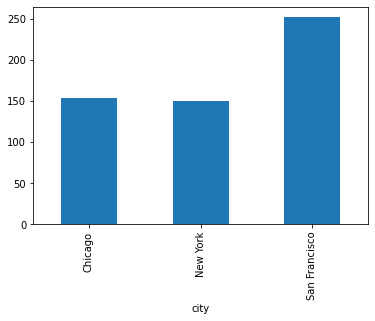

In [41]:
summary_df['Mean Price'].plot.bar()

C:\Users\whois\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


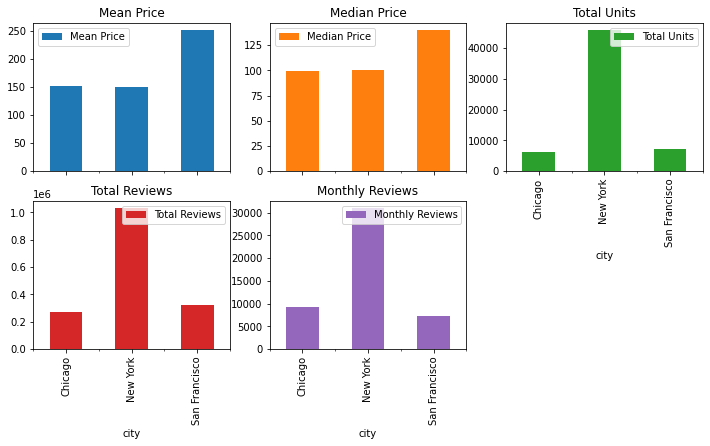

In [42]:
summary_df.plot.bar(subplots=True, layout=(2, 3), figsize=(12, 6))
plt.savefig("../City_Comparison.png")
plt.show()